In [1]:
import numpy as np 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.stats
import sklearn
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from collections import defaultdict
from sklearn.cluster import MiniBatchKMeans, KMeans 
from sklearn.metrics.pairwise import pairwise_distances_argmin 
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.mixture import GaussianMixture
import string
import csv
import seaborn as sns
from pandas import DataFrame
from matplotlib import colors
from imageio import imread

In [2]:
data_dir1 = "./Dataset Version 1/jester-data-1.xls"
data_dir2 = "./Dataset Version 1/jester-data-2.xls"
data_dir3 = "./Dataset Version 1/jester-data-3.xls"
df1 = pd.read_excel(data_dir1, header=None)
df2 = pd.read_excel(data_dir2, header=None)
df3 = pd.read_excel(data_dir3, header=None)
df = df1.append(df2).append(df3)
# df = pd.DataFrame(pd.read_excel(data_dir))

In [3]:
df.index = range(df.shape[0])
df.index.name = "User ID"
col_names = ["joke"+str(i) for i in range(1, df.shape[1])]
df.columns = ["NumRated"] + col_names
df[df==99.0] = np.nan
df = df.loc[:, df.columns != "NumRated"]
df.head(6)
df_gauge = df[["joke7", "joke8", "joke13", "joke15", "joke16", "joke17", "joke18", "joke19"]].copy() #[7, 8, 13, 15, 16, 17, 18, 19] 
df.head(6)

,joke1,joke2,joke3,joke4,joke5,joke6,joke7,joke8,joke9,joke10,...,joke91,joke92,joke93,joke94,joke95,joke96,joke97,joke98,joke99,joke100
User ID,,,,,,,,,,,,,,,,,,,,,
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
5,-6.17,-3.54,0.44,-8.50,-7.09,-4.32,-8.69,-0.87,-6.65,-1.80,...,-3.54,-6.89,-0.68,-2.96,-2.18,-3.35,0.05,-9.08,-5.05,-3.45


## Plot of histogram of average joke ratings

[Text(0.5, 0, 'Mean rating per user'), Text(0, 0.5, 'Count')]

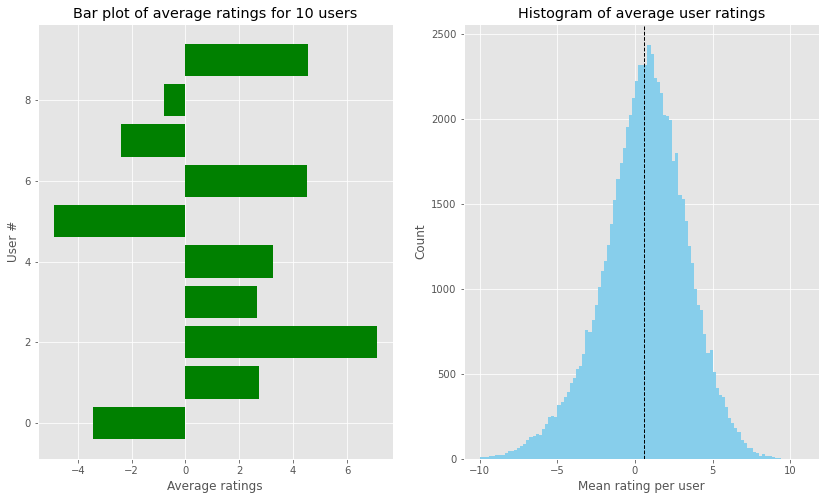

In [4]:
avg_joke_rating = np.nanmean(df,axis=0)
each_user_avg = np.nanmean(df,axis=1)
fig=plt.figure(figsize=(14,8)) 
plt.style.use('ggplot')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.hist(each_user_avg, np.arange(-10,11,0.2), color = "skyblue")
ax1.barh(np.arange(0,10),each_user_avg[:10], color='green')
ax1.set_title('Bar plot of average ratings for 10 users')
ax1.set(ylabel='User #', xlabel='Average ratings')
ax2.set_title('Histogram of average user ratings')
ax2.axvline(each_user_avg.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
# ax2.text(each_user_avg.mean()*1.1, max_ylim*0.96), 'Mean: {:.2f}'.format(each_user_avg.mean())) #mean = 0.6 
ax2.set(xlabel='Mean rating per user', ylabel='Count')

## Effect of joke length on rating

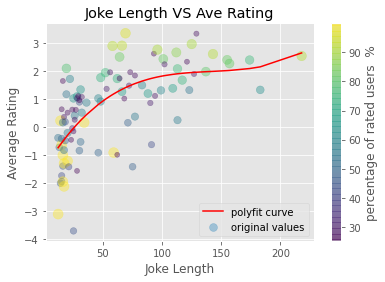

In [5]:
def takeFirst(elem):
    return elem[0]
df2 = df.copy() 
df2.loc['Row_sum'] = df.apply(lambda x: x.sum())
df2.loc['notnull'] = 73420-df.isnull().sum(axis=0)

joke_content_path = "jester_content.xlsx"
df_joke = pd.read_excel(joke_content_path, header=None)
num_jokes, _ = df_joke.values.shape
# Convert all jokes to string
joke_list = list()
feature_length = 512
from collections import defaultdict
words_dict = defaultdict(int)
word_list = []
len_joke = []
for index in range(num_jokes):
    joke = df_joke.values[index, 0]
    words = joke.split()
    len_joke.append(len(words))
    for each_word in words:
        words_dict[each_word] += 1
        word_list.append(each_word.lower())

word_nocomma = []
trantab = str.maketrans({key: None for key in string.punctuation})
for ind_word in word_list:
    j = ind_word.translate(trantab)
    word_nocomma.append(j)
    
words_count_dict = {k:v for k, v in sorted(words_dict.items(), key=lambda x: x[1], reverse=True)[0:feature_length]}
idx = 0
words_id = {}
for word, count in words_count_dict.items():
    words_id[word] = idx
    idx += 1

listkk = []
for i in range(0,100):
    listkk.append(df2.loc['Row_sum'][i]/df2.loc['notnull'][i])

df3=df2.loc[['notnull']]

listpopu = []
listave = listkk
listscore = []
for k in df3.loc['notnull']:
    listpopu.append(k/73420)
for j in df2.loc['Row_sum']:
    listscore.append(j)

list_avelen =[]
for k in range(0,len(len_joke)):
    li = [len_joke[k],listave[k],listpopu[k]]
    list_avelen.append(li)
list_avelen.sort(key = takeFirst)
len_joke = []
listave = []
listpopu = []
for k in range(0,len(list_avelen)):
    len_joke.append(list_avelen[k][0])
    listave.append(list_avelen[k][1])
    listpopu.append(list_avelen[k][2]*100)
colors = np.random.rand(len(len_joke)) 
z1 = np.polyfit(len_joke, listave, 3)
p1 = np.poly1d(z1) 
yvals=p1(len_joke)
plt.rcParams['savefig.dpi'] = 280
plot2=plt.plot(len_joke, yvals, 'r',label='polyfit curve')
plt.scatter(len_joke, listave,s=listpopu,marker='o',c=listpopu,label='original values',alpha=0.4)
plt.legend(loc=4)
plt.title('Joke Length VS Ave Rating')
plt.xlabel('Joke Length') 
plt.ylabel('Average Rating')

cb=plt.colorbar()
cb.set_label('percentage of rated users  %')
plt.savefig("length-aveScore.jpg")
plt.show()

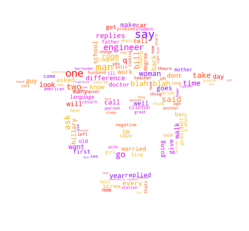

In [6]:
from matplotlib import colors
aa = ' '.join(word_nocomma)
color_list = ['#bf00ef','#ff7900','#fd0000','#7f00ef','#f1af00','#ff4000','#ef00df']
colormap=colors.ListedColormap(color_list)
image=imread('joker1.jpg')
wordcloud = WordCloud(relative_scaling=.3,mask=image, min_font_size=10, max_font_size=48,colormap=colormap, background_color='white').generate(' '.join(word_nocomma))
plt.rcParams['savefig.dpi'] = 280
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud.jpg")
plt.show()

In [7]:
#normalization
def normalize_data(dataframe): 
    mean_data = dataframe.sum(axis=1, numeric_only=True)/dataframe.count(1)
    mean_sub = dataframe.subtract(mean_data, axis='rows')
    mean_pow = mean_sub.pow(2, axis='columns')
    var = np.sqrt(mean_pow.sum(axis=1, numeric_only=True)/(mean_pow.count(1)-1))
    return mean_sub.divide(var, axis='rows')
    # return mean_sub
normalized_df = normalize_data(df)
normalized_df_gauge = normalize_data(df_gauge)

## Clustering users 

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1469 samples in 0.001s...
[t-SNE] Computed neighbors for 1469 samples in 0.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1469
[t-SNE] Computed conditional probabilities for sample 1469 / 1469
[t-SNE] Mean sigma: 4.872789
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.302170
[t-SNE] KL divergence after 500 iterations: 1.894271
(1469, 2)


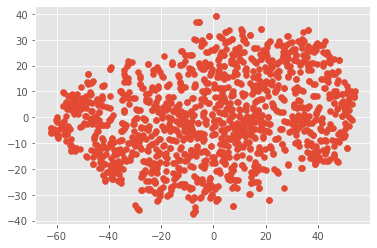

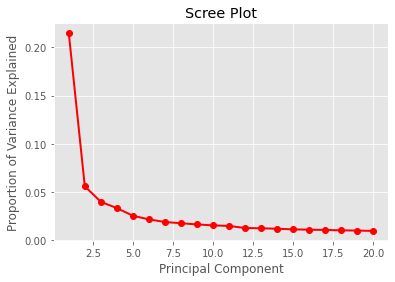

In [8]:
A = normalized_df.fillna(0.0).values
n_components = 20
pca = PCA(n_components=20)
pca.fit(A)
R = df.fillna(0.0).values.copy()
reduced_A = pca.fit_transform(R)
reduced_A_embedded = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=500).fit_transform(reduced_A[::50,:])
print(reduced_A_embedded.shape)
plt.scatter(reduced_A_embedded[:,0], reduced_A_embedded[:,1])
plt.show()
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

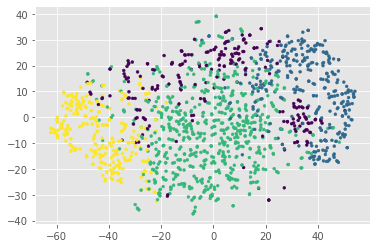

In [9]:
batch_size = 50
n_clusters = 4
mbk = MiniBatchKMeans(init ='k-means++', n_clusters = 4, max_iter=100000,batch_size = batch_size, n_init = 10, 
                      max_no_improvement = 10, verbose = 0) 
  
mbk.fit(reduced_A) 
y_kmeans = mbk.predict(reduced_A)
plt.scatter(reduced_A_embedded[:, 0], reduced_A_embedded[:, 1], c=y_kmeans[::50], s=8, cmap='viridis')

# model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
# model.fit(reduced_A[::100])
# labels = model.labels_
# plt.scatter(reduced_A_embedded[:,0], reduced_A_embedded[:,1], c=labels, s=5, cmap='viridis')

# model = GaussianMixture(n_components=4, random_state=0).fit(reduced_A)
# labels = model.predict(reduced_A)
# plt.scatter(reduced_A_embedded[:, 0], reduced_A_embedded[:, 1], c=labels[::100], s=5, cmap='viridis')

## UBCF visualizations

In [10]:
#similarity computation
def pearson(new_user, dataframe,m=20): 
    d1 = np.nansum(np.square(new_user)) 
    d2 = np.nansum(np.square(dataframe),axis=1)
    similar_users = np.nan_to_num(np.nansum(dataframe*new_user, axis=1)/np.sqrt(d1*d2))
    most_similar = np.sort(similar_users)[-m:]
    most_similar_idx = np.argsort(similar_users)[-m:]
    return (most_similar, most_similar_idx)

def top_similar_jokes(most_similar, top_user_matrix): 
    scores_matrix = top_user_matrix.copy() 
    top_jokes = np.nansum(top_user_matrix.T * most_similar, axis=1)/np.sum(most_similar)
    top_5 = np.argsort(top_jokes)[-5:]
    return top_5,top_jokes



Top 5 recommended jokes: [64 67 53 26 28]
Actual rankings given by the user:
joke65    2.82
joke68    8.30
joke54    8.30
joke27    7.82
joke29    9.13
Name: 0, dtype: float64
<ipython-input-10-f94576f63026>:5: RuntimeWarning: invalid value encountered in true_divide
  similar_users = np.nan_to_num(np.nansum(dataframe*new_user, axis=1)/np.sqrt(d1*d2))


Text(0, 0.5, 'Jokes recommended')

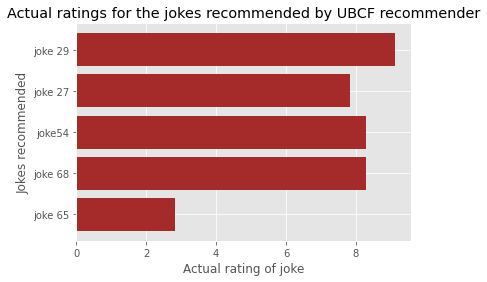

In [11]:
# gauge_set = [7, 8, 13, 15, 16, 17, 18, 19] 
gauge_set = list(range(100))
new_user = normalized_df.iloc[0].copy() 
new_user[:] = np.nan
new_user.iloc[gauge_set] = normalized_df.iloc[0,gauge_set]
most_similar, most_similar_idx = pearson(new_user,normalized_df)
top_user_matrix = normalized_df.iloc[most_similar_idx].copy()
top_5,_ = top_similar_jokes(most_similar, top_user_matrix)
print("Top 5 recommended jokes:", top_5)
print("Actual rankings given by the user:\n{}".format(df.iloc[0, list(top_5)]))
plt.style.use('ggplot')
plt.barh(["joke 65", "joke 68", "joke54", "joke 27", "joke 29"],list(df.iloc[0, list(top_5)]), color='brown')
plt.title('Actual ratings for the jokes recommended by UBCF recommender')
plt.xlabel('Actual rating of joke')
plt.ylabel('Jokes recommended')

<ipython-input-10-f94576f63026>:5: RuntimeWarning: invalid value encountered in true_divide
  similar_users = np.nan_to_num(np.nansum(dataframe*new_user, axis=1)/np.sqrt(d1*d2))
20
(20,)


Text(0, 0.5, 'RMS Error')

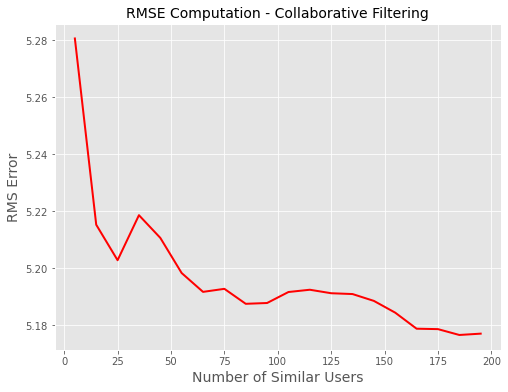

In [12]:
def recommendation(new_user,df,m):
    gauge_set = list(range(100))
    new_user[:] = np.nan
    new_user.iloc[gauge_set] = normalized_df.iloc[132,gauge_set]
    most_similar, most_similar_idx = pearson(new_user,normalized_df,m)
    top_user_matrix = normalized_df.iloc[most_similar_idx].copy()
    top_5,top_jokes = top_similar_jokes(most_similar, top_user_matrix)

    return top_5,top_jokes
#RMSE Computation 

#Goal is to find the optimum number of similar users


sample_users=10
sample_idx=np.random.choice(df.shape[0],sample_users)
df_remove=df.iloc[sample_idx,-30:].copy() 
df_test=df.copy()
df_test.iloc[sample_idx,-30:]=np.nan #removing 30 values from subset to compute rmse for different similar users
sim_users=np.arange(5,205,10)
rmse_output=[]
for sim in sim_users:
    score=df_test.iloc[sample_idx].apply(lambda user:recommendation(user,df_test,sim),axis=1)
    score_revised=np.ndarray((score.size,30))
    for idx,point in enumerate(score):
        score_revised[idx]=point[1][-30:]
    rmse_value=(df_remove-score_revised).to_numpy()
    rmse_plot=rmse_value[~np.isnan(rmse_value)]
    rmse_score=np.sqrt(np.sum(np.power(rmse_plot,2))/len(rmse_plot))
    rmse_output.append(rmse_score)
        
#PLOT RMSE RESULTS
print(len(rmse_output))
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
print(sim_users.shape)
ax.plot(np.array(sim_users), np.array(rmse_output),c='r',linewidth=2.0)
ax.set_title("RMSE Computation - Collaborative Filtering",fontsize=14)
ax.set_xlabel("Number of Similar Users",fontsize=14)
ax.set_ylabel("RMS Error",fontsize=14)

## TF-IDF visualizations

In [13]:
#TF-IDF score calculation
jokes_dir = "jester_content.xlsx"
df_joke = pd.read_excel(jokes_dir, header=None)
num_jokes, _ = df_joke.values.shape
joke_corpus = []
for index in range(num_jokes):
    joke = df_joke.values[index, 0]
    joke_corpus.append(joke)
tf_idf_vectorizer = TfidfVectorizer(use_idf=True)
tf_idf_matrix = tf_idf_vectorizer.fit_transform(joke_corpus)
# print(len(tf_idf_vectorizer.get_feature_names()))
# print(tf_idf_matrix[79,:])
# print((np.array(tf_idf_matrix[79,:].todense()).tolist()[0]))
lst_df=[]
for elem in [57,15,14,43,12]: 
    df_tf_ratings = pd.DataFrame(tf_idf_matrix[elem,:].T.todense(),index=tf_idf_vectorizer.get_feature_names(), columns=["TF-IDF"]) 
    df_tf_ratings = df_tf_ratings.sort_values('TF-IDF', ascending=False)
    lst_df.append(df_tf_ratings)
d = defaultdict(float)
for i in lst_df:
    count=1
    for idx in i.index:
        d[idx]+=i['TF-IDF'][idx]
        count+=1
        if count==15: 
            break

              TF-IDF
shampoo     0.276485
lather      0.276485
shower      0.276485
repeat      0.276485
keep        0.276485
label       0.276485
rinse       0.276485
computer    0.276485
programmer  0.276485
give        0.225014
long        0.214772
day         0.198612
them        0.180723
all         0.167176
how         0.150022
with        0.144400
do          0.136899
says        0.130282
(30, 1559)


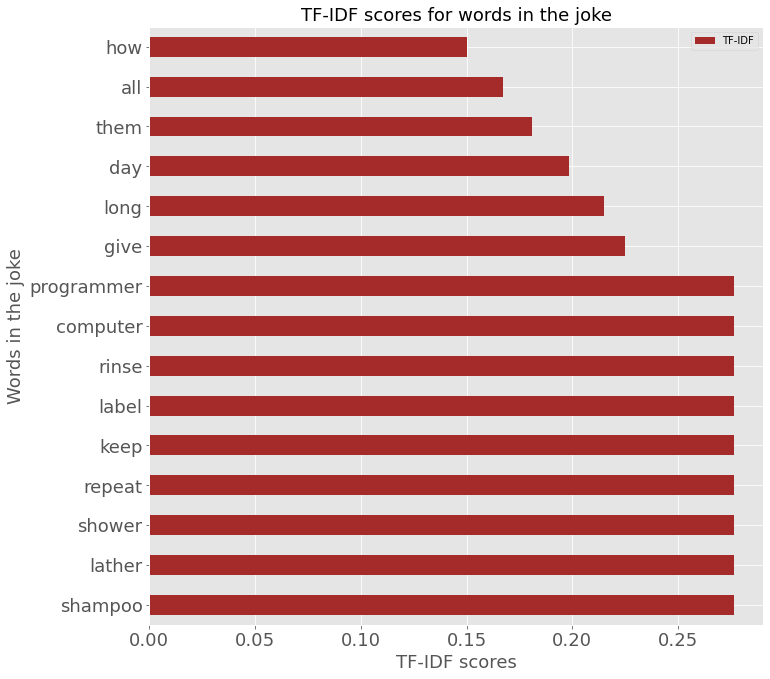

In [14]:
#TF-IDF scores of sample joke
df_tf_ratings_81 = pd.DataFrame(tf_idf_matrix[81,:].T.todense(),index=tf_idf_vectorizer.get_feature_names(), columns=["TF-IDF"]) 
df_tf_ratings_81 = df_tf_ratings_81.sort_values('TF-IDF', ascending=False)
print(df_tf_ratings_81[:18])
df_tf_ratings_81[:15].plot.barh(figsize=(11,11), color='brown')
plt.xlabel("TF-IDF scores", fontsize=18)
plt.ylabel("Words in the joke", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('TF-IDF scores for words in the joke', fontsize=18)
print(tf_idf_matrix.toarray()[70:,:].shape)

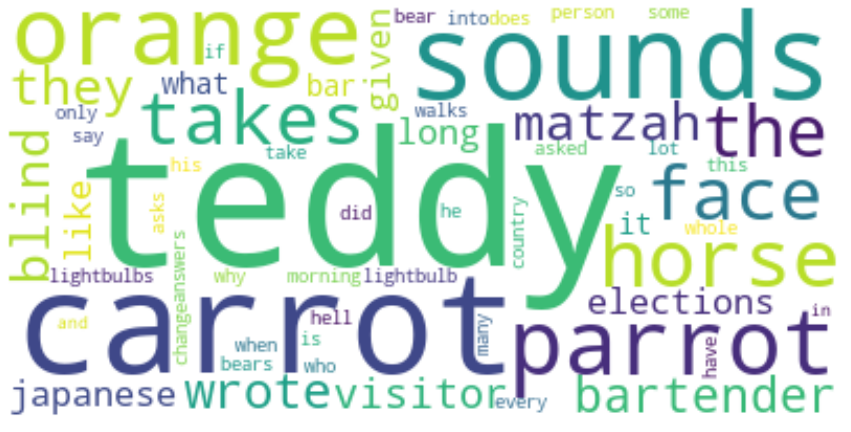

In [15]:
#word cloud of top 5 highest rated jokes 
Cloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(frequencies=d)
plt.figure(figsize=(15,15))
plt.imshow(Cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Visualizing content information

In [16]:
#JOKE CONTENT BASED ANALYSIS

#=================================================================
#========= STEP -1: Categorizing the Jokes =======================

joke_content = np.zeros((df.shape[1], 15))

joke_cat=["Q/A Format", "Medical", "Political", "Religious", "Race/Nationality", "Career/Profession", "Relationships", "Gender-Based","Drinking/Social Activities", "Current Affairs", "Puns", "Family", "Technology", "Animals", "Humans Acting Stupid"]

#Hard-coded category matrix for all the 100 jokes after manual analysis
joke_content[0] = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[1] = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[2] = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[3] = [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
joke_content[4] = [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
joke_content[5] = [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
joke_content[6] = [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]
joke_content[7] = [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[8] = [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
joke_content[9] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
joke_content[10] = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[11] = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[12] = [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
joke_content[13] = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
joke_content[14] = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[15] = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
joke_content[16] = [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]
joke_content[17] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
joke_content[18] = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[19] = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
joke_content[20] = [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
joke_content[21] = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
joke_content[22] = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[23] = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
joke_content[24] = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
joke_content[25] = [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
joke_content[26] = [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
joke_content[27] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
joke_content[28] = [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
joke_content[29] = [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[30] = [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
joke_content[31] = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[32] = [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[33] = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[34] = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[35] = [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
joke_content[36] = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
joke_content[37] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
joke_content[38] = [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
joke_content[39] = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
joke_content[40] = [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[41] = [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
joke_content[42] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
joke_content[43] = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
joke_content[44] = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
joke_content[45] = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[46] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[47] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[48] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[49] = [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[50] = [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
joke_content[51] = [1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
joke_content[52] = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
joke_content[53] = [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[54] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
joke_content[55] = [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
joke_content[56] = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
joke_content[57] = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
joke_content[58] = [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[59] = [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[60] = [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
joke_content[61] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[62] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[63] = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[64] = [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
joke_content[65] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[66] = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
joke_content[67] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[68] = [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
joke_content[69] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[70] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
joke_content[71] = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[72] = [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
joke_content[73] = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
joke_content[74] = [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
joke_content[75] = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
joke_content[76] = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[77] = [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[78] = [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[79] = [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
joke_content[80] = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
joke_content[81] = [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
joke_content[82] = [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
joke_content[83] = [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[84] = [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
joke_content[85] = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
joke_content[86] = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[87] = [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[88] = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[89] = [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]
joke_content[90] = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]
joke_content[91] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[92] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
joke_content[93] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
joke_content[94] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
joke_content[95] = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
joke_content[96] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
joke_content[97] = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
joke_content[98] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
joke_content[99] = [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

#========================================================================================
#==================================== STEP -2 ===========================================
#Finding the Category of all the 100 jokes based on the user-defined category matrix above

count=[0]*15
joke_cat_100=[]*len(joke_content)
for n,joke in enumerate(joke_content):
    for index in range(len(joke)):
        if joke[index]==1:
            count[index]=count[index]+1
            category=joke_cat[index]
            joke_cat_100.append(category)
            

title=["S no.","Category"]
rows=zip(range(1,100,1),joke_cat_100)
with open('joke_category.csv', 'w',newline="" ) as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(title)
    wr.writerows(rows)

#=======================================================================
#========================== STEP -3 ====================================
# Find each joke's average rating
joke_avg = np.nanmean(df, axis=0)

joke_avg_score=np.array(joke_avg)
joke_avg_index = np.argsort(joke_avg_score) 

top_20=joke_avg_index[:20]

joke_avg_score=np.sort(joke_avg_score)[::-1]


#Finding category of Top 20 jokes

top_20_cat=[]
for i in range(len(joke_cat_100)):
    for j in range(len(top_20)):
        if top_20[j]==i:
            top_20_cat.append(joke_cat_100[i])

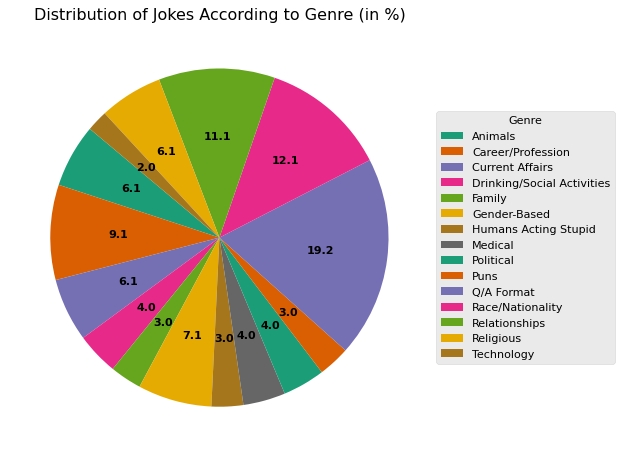

In [17]:
#VISUALIZATIONS 

#print("Avg score: ",joke_avg_score[:20],"\n\n\n\n\nJoke Index: ",joke_avg_index,"\n\n\n",top_10)
df_plot=pd.read_csv(r"./joke_category.csv")



df_new = df_plot.groupby('Category').size().reset_index(name='counts')

fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

data = df_new['counts']
categories = df_new['Category']
#explode = [0.05,0.05,0.05,0,0,0,0,0,0,0,0.05,0.05,0.05,0,0]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="black"), 
                                  colors=plt.cm.Dark2.colors,
                                 startangle=140)

# Decoration
ax.legend(wedges, categories, title="Genre", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Distribution of Jokes According to Genre (in %)")
plt.show()



Text(0.5, 1.02, 'Genres of Top 20 Highest Rated Jokes')

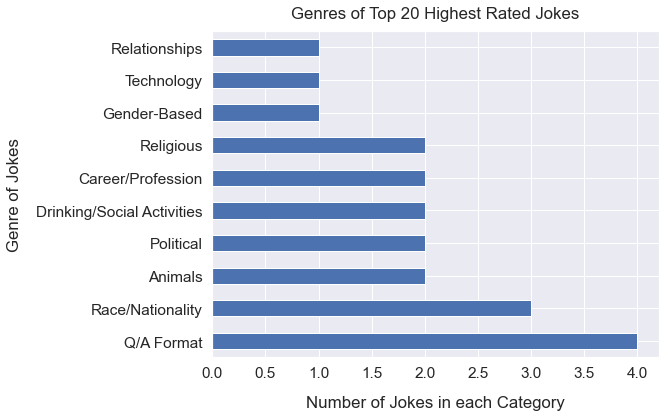

In [18]:
#Categories of Top 20 Jokes 
df_top20=DataFrame(top_20_cat,columns=['Category'])
sns.set(font_scale=1.4)
df_top20['Category'].value_counts().plot(kind='barh', figsize=(8, 6), rot=0)
plt.xlabel("Number of Jokes in each Category", labelpad=14)
plt.ylabel("Genre of Jokes", labelpad=14)
plt.title("Genres of Top 20 Highest Rated Jokes", y=1.02)

((100, 1559), (1559,))
Top 5 recommended jokes: [28 64 53 13  1]
Actual user ratings for recommended jokes: joke29    9.13
joke65    2.82
joke54    8.30
joke14    8.45
joke2     8.79
Name: 0, dtype: float64
<ipython-input-19-aa8145daebb4>:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  user_profile = np.nanmean(tf_idf_dict * normalized_user[:, np.newaxis], axis=0)


Text(0, 0.5, 'Jokes recommended')

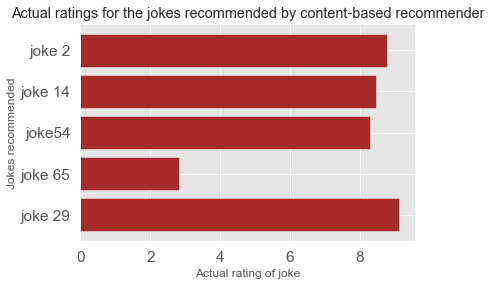

In [19]:
#content-based system
def content_based(normalized_user, tf_idf_dict, unseen_jokes, n=5):
    user_profile = np.nanmean(tf_idf_dict * normalized_user[:, np.newaxis], axis=0)
    norm_unseen = np.sqrt(np.nansum(np.power(unseen_jokes, 2), axis=1))
    norm_user = np.sqrt(np.nansum(np.power(user_profile, 2)))
    print((unseen_jokes.shape, user_profile.T.shape))
    #cosine similarity between user profile and unseen joke matrix
    dot_product = np.nansum(unseen_jokes * user_profile.T, axis=1)
    pred_rating = dot_product / (norm_unseen * norm_user)
    recommended_jokes = np.argsort(pred_rating)[-n:]
    return recommended_jokes, pred_rating
# tf_idf_matrix.todense().shape
known = 100
# test_user = normalized_df.iloc[0,(100-known):]
test_user = normalized_df.iloc[0,:]
# recommended_jokes, predicted_rating = content_based(test_user, tf_idf_matrix.toarray()[(100-known):,:], tf_idf_matrix.toarray()[:(100-known),:], 5)
recommended_jokes, predicted_rating = content_based(test_user, tf_idf_matrix.toarray(), tf_idf_matrix.toarray(), 5)
print("Top 5 recommended jokes:",recommended_jokes)
print("Actual user ratings for recommended jokes:", df.iloc[0, recommended_jokes]) #results from collab: [64 67 53 26 28]
plt.style.use('ggplot')
plt.barh(["joke 29", "joke 65", "joke54", "joke 14", "joke 2"],list(df.iloc[0, recommended_jokes]), color='brown')
plt.title('Actual ratings for the jokes recommended by content-based recommender')
plt.xlabel('Actual rating of joke')
plt.ylabel('Jokes recommended')